<h1> Taxi Prediction </h1> <br>
** Bild **

In [ ]:
!nvidia-smi

Thu Sep 17 18:21:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Install RAPIDS and Dask_ml
!pip install dask_ml
!pip install dask_cuda

!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh stable


import sys, os

dist_package_index = sys.path.index('/usr/local/lib/python3.6/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.6/site-packages'] + sys.path[dist_package_index:]
sys.path
exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

     |████████████████████████████████| 143kB 2.8MB/s 
     |████████████████████████████████| 6.8MB 8.1MB/s 
     |████████████████████████████████| 655kB 37.6MB/s 
     |████████████████████████████████| 92kB 10.2MB/s 
     |████████████████████████████████| 102kB 11.3MB/s 
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7666 sha256=d83e13495143c354687f43948875a0e182e53dee5ce91fd6fb482e3b3a8e95c6
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
  Created wheel for locket: filename=locket-0.2.0-cp36-none-any.whl size=4040 sha256=9e64cacab009498c0ba2ea8848dabfb131345f82af6eb6b96fc186ee25684f68
  Stored in directory: /root/.cache/pip/wheels/26/1e/e8/4fa236ec931b1a0cdd61578e20d4934d7bf188858723b84698
Successfully built contextvars locket
ERROR: tensorflow-probability 0.11.0 has requirement cloudpickle==1.3, but you'll have cloudpickle 1.6.0 which is incompatible.
ERROR: gym 0.17.2 has requirement c

In [ ]:
import nvstrings
import numpy as np
import cudf, cuml
import dask_cudf
import io, requests
import math
import gc
import cupy as cp
import pandas as pd

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns 

#Learning
from cuml.preprocessing.model_selection import train_test_split
from scipy.stats import uniform

# Linear Models
from cuml.linear_model import LinearRegression # Linear
from cuml.linear_model import LogisticRegression # Logisitc
from cuml.linear_model import ElasticNet # Elastic
from cuml.linear_model import Ridge # Ridge
from cuml.linear_model import Lasso # Lasso
from cuml.linear_model import MBSGDRegressor as cumlMBSGDRegressor # Mini Batch SGD Regressor

from cuml.solvers import SGD as cumlSGD # Stochastic Gradient Descent
from cuml.ensemble import RandomForestRegressor as cuRF # Random Forest
from cuml.neighbors import KNeighborsRegressor  # Nearest Neighbours
from cuml.svm import SVC # Support Vector Machines

from cuml import ForestInference
import xgboost as xgb

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from cuml.metrics.regression import r2_score
from cuml.metrics.accuracy import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score as sk_acc
from sklearn.utils.fixes import loguniform

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: nvstrings will be removed in 0.15. Please use equivalent from libcudf
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
cudf.set_allocator("managed")
dtype = {'fare_amount': 'float32',
              'pickup_datetime':'str',
              'pickup_longitude': 'float32',
              'pickup_latitude': 'float32',
              'dropoff_longitude': 'float32',
              'dropoff_latitude': 'float32',
              'passenger_count': 'int8'}

usecols = list(dtype.keys())

In [ ]:
%%time
#use a subset with 2.500.000 rows
nrows = 2500000

test = cudf.read_csv('/content/drive/My Drive/Colab Notebooks/test_taxi.csv', nrows=nrows, usecols=usecols, dtype=dtype)
train = cudf.read_csv('/content/drive/My Drive/Colab Notebooks/train.csv', nrows=nrows, usecols=usecols, dtype=dtype)

CPU times: user 1.02 s, sys: 644 ms, total: 1.66 s
Wall time: 9.77 s


In [ ]:
train.head(5)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844307,40.721321,-73.841614,40.712273,1
1,16.9,2010-01-05 16:52:16 UTC,-74.016045,40.711304,-73.979271,40.782005,1
2,5.7,2011-08-18 00:35:00 UTC,-73.982742,40.761269,-73.991234,40.750565,2
3,7.7,2012-04-21 04:30:42 UTC,-73.987137,40.733139,-73.991570,40.758095,1
4,5.3,2010-03-09 07:51:00 UTC,-73.968102,40.768009,-73.956665,40.783768,1


In [ ]:
test.head(5)

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739197,1
2,2011-10-08 11:53:44 UTC,-73.982536,40.751259,-73.979668,40.746140,1
3,2012-12-01 21:12:12 UTC,-73.981163,40.767811,-73.990440,40.751633,1
4,2012-12-01 21:12:12 UTC,-73.966042,40.789776,-73.988579,40.744431,1


In [ ]:
#Drop Nan Values
train.nans_to_nulls()
train = train.dropna()

In [ ]:
#Checking shape of the data
print("Train: " + str(train.shape))
print("Test: " + str(test.shape))

Train: (2499981, 7)
Test: (9914, 6)


In [ ]:
#Changing the data format of pickup_datetime and adding additional information about pickup time
train['pickup_datetime'] = train['pickup_datetime'].astype('datetime64[ns]')

train["hour"] = train.pickup_datetime.dt.hour
train["weekday"] = train.pickup_datetime.dt.weekday
train["month"] = train.pickup_datetime.dt.month
train["year"] = train.pickup_datetime.dt.year


test['pickup_datetime'] = test['pickup_datetime'].astype('datetime64[ns]')

test["hour"] = test.pickup_datetime.dt.hour
test["weekday"] = test.pickup_datetime.dt.weekday
test["month"] = test.pickup_datetime.dt.month
test["year"] = test.pickup_datetime.dt.year

In [ ]:
#calculate trip distance in miles
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))

In [ ]:
train['distance'] = distance(train['pickup_latitude'], train['pickup_longitude'], train['dropoff_latitude'], train['dropoff_longitude'] )
test['distance'] = distance(test['pickup_latitude'], test['pickup_longitude'], test['dropoff_latitude'], test['dropoff_longitude'] )
train['distance'].describe()

count    2.499981e+06
mean     1.197891e+01
std      2.291315e+02
min      0.000000e+00
25%      0.000000e+00
50%      1.366828e+00
75%      2.367415e+00
max      1.076849e+04
Name: distance, dtype: float64

In [ ]:
#check if everything worked
train.head(2)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,weekday,month,year,distance
0,4.5,2009-06-15 17:26:21,-73.844307,40.721321,-73.841614,40.712273,1,17,0,6,2009,0.000000
1,16.9,2010-01-05 16:52:16,-74.016045,40.711304,-73.979271,40.782005,1,16,1,1,2010,5.244397


In [ ]:
test.head(2)

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,weekday,month,year,distance
0,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,1,13,1,1,2015,1.366828
1,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739197,1,13,1,1,2015,1.366828


In [ ]:
print("Ararage fare amount: " + str(train['fare_amount'].mean()))
print("Standard deviation fare amount: " + str(train['fare_amount'].std()))
print("Ararage distance: " + str(train['distance'].mean()) + " miles")
print("Standard deviation distance: " + str(train['distance'].std()) + " miles")

Ararage fare amount: 11.344576213919874
Standard deviation fare amount: 9.838256383443909
Ararage distance: 11.978906942839938 miles
Standard deviation distance: 229.13152955656096 miles


In [ ]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,weekday,month,year,distance
count,2.499981e+06,2.499981e+06,2.499981e+06,2.499981e+06,2.499981e+06,2.499981e+06,2.499981e+06,2.499981e+06,2.499981e+06,2.499981e+06,2.499981e+06
mean,1.134458e+01,-7.251699e+01,3.992711e+01,-7.251614e+01,3.992419e+01,1.683927e+00,1.351102e+01,3.041872e+00,6.266912e+00,2.011740e+03,1.197891e+01
std,9.838256e+00,1.286141e+01,8.343408e+00,1.267979e+01,1.007531e+01,1.308228e+00,6.514190e+00,1.949401e+00,3.435580e+00,1.860683e+00,2.291315e+02
min,-6.200000e+01,-3.377681e+03,-3.458665e+03,-3.383297e+03,-3.461541e+03,-4.800000e+01,0.000000e+00,0.000000e+00,1.000000e+00,2.009000e+03,0.000000e+00
25%,6.000000e+00,-7.399206e+01,4.073492e+01,-7.399139e+01,4.073402e+01,1.000000e+00,9.000000e+00,1.000000e+00,3.000000e+00,2.010000e+03,0.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075315e+01,1.000000e+00,1.400000e+01,3.000000e+00,6.000000e+00,2.012000e+03,1.366828e+00
75%,1.250000e+01,-7.396712e+01,4.076711e+01,-7.396368e+01,4.076811e+01,2.000000e+00,1.900000e+01,5.000000e+00,9.000000e+00,2.013000e+03,2.367415e+00
max,1.273310e+03,2.856441e+03,2.912464e+03,3.414307e+03,3.345917e+03,9.000000e+00,2.300000e+01,6.000000e+00,1.200000e+01,2.015000e+03,1.076849e+04


Visualization of the data <br>

The following things were noticed (while using 500k datapoints):
*   The minimal fare_amount is negative. As this does not seem to be realistic I will drop them from the dataset.
*   Some of the minimum and maximum longitude/lattitude coordinates are way off. These  will also be remove from the dataset. (bounding box will be defined)
*   The average fare_amount is about 9.79 USD with a standard deviation of 7.48 USD. When building a predictive model we want to be better than 7.48 USD.



In [ ]:
train = train[train.fare_amount>=0]
train = train[(train['distance'] < 30) & (train['distance'] >=0 )]

In [ ]:
fare_amount = train['fare_amount'].to_array()
passenger_count = train['passenger_count'].to_array()
distance = train['distance'].to_array()

Text(0.5, 1.0, 'Verteilung des Fahrpreises')

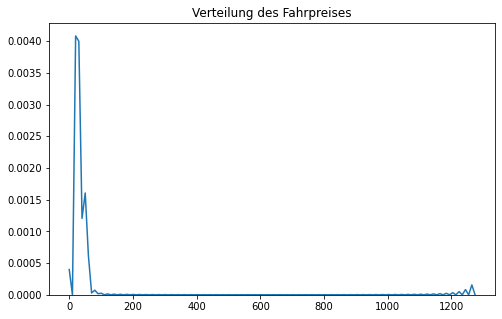

In [ ]:
plt.figure(figsize=(8,5))
sns.kdeplot(fare_amount).set_title("Verteilung des Fahrpreises")

Text(0.5, 1.0, 'Distanz')

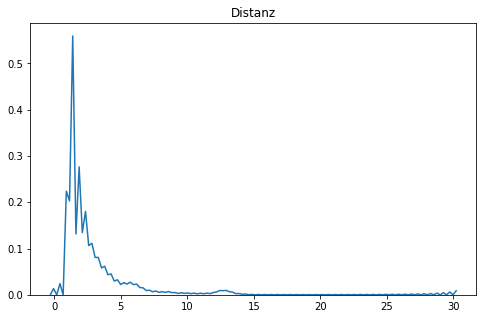

In [ ]:
plt.figure(figsize=(8,5))
sns.kdeplot(distance).set_title("Distanz")

In [ ]:
#check max latitude und max longitude of test data
print("Max lat pickup: " + str(test['pickup_latitude'].max()))
print("Max lat dropoff: " + str(test['dropoff_latitude'].max()))
print("Max lon pickup: " + str(test['pickup_longitude'].max()))
print("Max lon dropoff: " + str(test['dropoff_longitude'].max()))
print("")
print("Min lat pickup: " + str(test['pickup_latitude'].min()))
print("Min lat dropoff: " + str(test['dropoff_latitude'].min()))
print("Min lon pickup: " + str(test['pickup_longitude'].min()))
print("Min lon dropoff: " + str(test['dropoff_longitude'].min()))

Max lat pickup: 41.709553
Max lat dropoff: 41.696682
Max lon pickup: -72.986534
Max lon dropoff: -72.99096

Min lat pickup: 40.57314
Min lat dropoff: 40.568974
Min lon pickup: -74.25219
Min lon dropoff: -74.26323


Bounding Box New York
<table>
  <tr>
    <th></th>
    <th>Dropoff</th>
    <th>Pickup</th>
  </tr>
  <tr>
    <td>Max Long</td>
    <td>-72.99096</td>
    <td>-72.986534</td>
   </tr>
   <tr>
    <td>Max Lat</td>
    <td>41.696682</td>
    <td>41.709553</td>
   </tr>
   <tr>
    <td>Min Long</td>
    <td>-74.26323</td>
    <td>-74.25219</td>
    </tr>
   <tr>
    <td>Min Lat</td>
    <td>40.568974</td>
    <td>40.57314</td>
   </tr>
</table>



In [ ]:
train.head(2)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,weekday,month,year,distance
0,4.5,2009-06-15 17:26:21,-73.844307,40.721321,-73.841614,40.712273,1,17,0,6,2009,0.000000
1,16.9,2010-01-05 16:52:16,-74.016045,40.711304,-73.979271,40.782005,1,16,1,1,2010,5.244397


In [ ]:
#Parts of train data are too far away, so they can be dropped
train = train[(train['pickup_longitude'] > -74.25) & (train['pickup_longitude'] < -72.98)]
train = train[(train['pickup_latitude'] > 40.57) & (train['pickup_latitude'] < 41.70)]
train = train[(train['dropoff_longitude'] < -72.99) & (train['dropoff_longitude'] > -74.26)]
train = train[(train['dropoff_latitude'] > 40.56) & (train['dropoff_latitude'] < 41.69)]

(-74.03, -73.75)

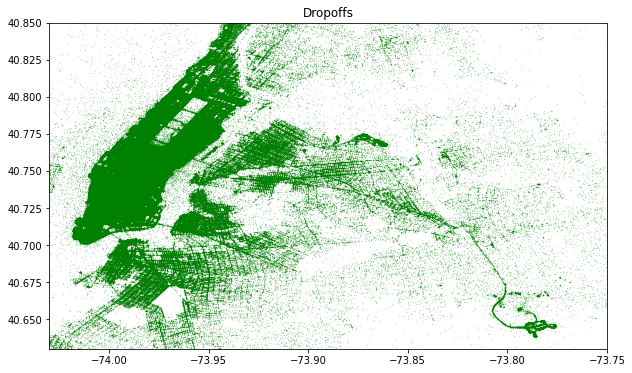

In [ ]:
dropoff_longitude = train['dropoff_longitude'].to_array()
dropoff_latitude = train['dropoff_latitude'].to_array()

city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

plt.figure(figsize=(10,6))
plt.scatter(dropoff_longitude, dropoff_latitude,
                color='green', 
                s=.02, alpha=.6)
plt.title("Dropoffs")

plt.ylim(city_lat_border)
plt.xlim(city_long_border)

In [ ]:
unnecessary_columns=['pickup_datetime','dropoff_latitude','pickup_latitude','dropoff_longitude','pickup_longitude']
train=train.drop(unnecessary_columns,axis=1)
test=test.drop(unnecessary_columns,axis=1)

In [ ]:
train.head(2)

,fare_amount,passenger_count,hour,weekday,month,year,distance
0,4.5,1,17,0,6,2009,0.000000
1,16.9,1,16,1,1,2010,5.244397


In [ ]:
X=train.drop(['fare_amount'],axis=1)
y=train['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
print("Number of records in training data ",X_train.shape[0])
print("Number of records in validation data ",X_test.shape[0])
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

Number of records in training data  1957016
Number of records in validation data  489254
(1957016, 6)
(489254, 6)
(1957016,)
(489254,)


Linear Regression

In [ ]:
lm = LinearRegression(fit_intercept = True, normalize = False,
                      algorithm = "eig")
lm.fit(X_train,y_train)
y_pred=lm.predict(X_test)
lm_rmse = r2_score(y_pred, y_test)
print("RMSE for Linear Regression is ",lm_rmse)

RMSE for Linear Regression is  0.6171725392341614


In [ ]:
y_pred=lm.predict(test)
y_pred

0       11.071411
1       11.071411
2        4.619019
3       10.106567
4       16.544556
          ...    
9909    11.154541
9910    14.177246
9911    47.622925
9912    24.078247
9913     6.164795
Length: 9914, dtype: float32

In [ ]:
gdf_submission = cudf.read_csv('/content/drive/My Drive/Colab Notebooks/sample_submission.csv')
gdf_submission['fare_amount']= y_pred

gdf_submission.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.071411
1,2015-01-27 13:08:24.0000003,11.071411
2,2011-10-08 11:53:44.0000002,4.619019
3,2012-12-01 21:12:12.0000002,10.106567
4,2012-12-01 21:12:12.0000003,16.544556


In [ ]:
gdf_submission.to_csv('/content/drive/My Drive/Colab Notebooks/submission1.csv',index=False)

Ridge Regression

In [ ]:
X=train.drop(['fare_amount'],axis=1)
y=train['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
print("Number of records in training data ",X_train.shape[0])
print("Number of records in validation data ",X_test.shape[0])
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

Number of records in training data  1957016
Number of records in validation data  489254
(1957016, 6)
(489254, 6)
(1957016,)
(489254,)


In [ ]:
params_ridge = {
    "alpha": loguniform(1e-5, 1e0), # default 1.0
    "solver": ['eig', 'cd'], 
}
ridge = Ridge()
clf = RandomizedSearchCV(ridge, params_ridge, random_state=1, n_iter=100, cv=5, verbose=0, n_jobs=1)
best_model = clf.fit(X_train,y_train)

In [ ]:
best_model.best_estimator_.get_params()

{'alpha': 0.001216494146415184,
 'fit_intercept': True,
 'normalize': False,
 'solver': 'eig'}

In [ ]:
ridge_params = {
 'alpha': 0.240960447726532,
 'fit_intercept': True,
 'normalize': False,
 'solver': 'eig'
}

ridge = Ridge(**ridge_params)
result_ridge = ridge.fit(X_train,y_train)

y_pred = result_ridge.predict(X_test)
ridge_rmse = r2_score(y_pred, y_test)
print("RMSE for Ridge_rmse Regression is ", ridge_rmse)

RMSE for Ridge_rmse Regression is  -1.2301888465881348


In [ ]:
y_pred

0          8.200073
1          6.368286
2         -3.951538
3         38.550537
4         -2.398804
            ...    
489249    -5.762573
489250    -6.499634
489251     1.669678
489252    -7.567871
489253     3.752930
Length: 489254, dtype: float32

In [ ]:
gdf_submission = cudf.read_csv('/content/drive/My Drive/Colab Notebooks/sample_submission.csv')
gdf_submission['fare_amount']= y_pred

gdf_submission.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,8.200073
1,2015-01-27 13:08:24.0000003,6.368286
2,2011-10-08 11:53:44.0000002,-3.951538
3,2012-12-01 21:12:12.0000002,38.550537
4,2012-12-01 21:12:12.0000003,-2.398804


In [ ]:
gdf_submission.to_csv('/content/drive/My Drive/Colab Notebooks/submission2.csv',index=False)

Lasso Regression

In [ ]:
fare_amount = train['fare_amount'].to_array()
passenger_count = train['passenger_count'].to_array()
hour = train["hour"].to_array()
weekday = train["weekday"].to_array()
month =train["month"].to_array()
year = train["year"].to_array()
distance = train["distance"].to_array()

In [ ]:
X=train.drop(['fare_amount'],axis=1)
y=train['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
print("Number of records in training data ",X_train.shape[0])
print("Number of records in validation data ",X_test.shape[0])
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

Number of records in training data  1957016
Number of records in validation data  489254
(1957016, 6)
(489254, 6)
(1957016,)
(489254,)


In [ ]:
params_lasso = {
    "alpha": loguniform(1e-5, 1e0),
    "max_iter": np.arange(start=500, stop = 3000, step = 500),
    "tol": loguniform(1e-5, 1e0), 
    "selection": ['cyclic', 'random'],
}

lasso = Lasso()
clf = RandomizedSearchCV(lasso, params_lasso, random_state=1, n_iter=1000, cv=5, verbose=0, n_jobs=1)
best_model = clf.fit(X_train,y_train) 
best_model.best_estimator_.get_params()

{'alpha': 0.001216494146415184,
 'fit_intercept': True,
 'max_iter': 2500,
 'normalize': False,
 'selection': 'cyclic',
 'tol': 1.0013176560941263e-05}

In [ ]:
lasso_params = best_model.best_estimator_.get_params() 

lasso = Lasso(**lasso_params)
result_lasso = lasso.fit(X_train,y_train)
y_pred=result_lasso.predict(X_test)
lasso_rmse = r2_score(y_pred, y_test)
print("RMSE for Lasso Regression is ", lasso_rmse)

y_pred = result_lasso.predict(test)

RMSE for Lasso Regression is  0.6381998062133789


In [ ]:
gdf_submission = cudf.read_csv('/content/drive/My Drive/Colab Notebooks/sample_submission.csv')
gdf_submission['fare_amount']= y_pred

gdf_submission.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.063232
1,2015-01-27 13:08:24.0000003,11.063232
2,2011-10-08 11:53:44.0000002,4.630249
3,2012-12-01 21:12:12.0000002,10.105957
4,2012-12-01 21:12:12.0000003,16.537598


In [ ]:
gdf_submission.to_csv('/content/drive/My Drive/Colab Notebooks/submission3.csv',index=False)

Random Forrest

In [ ]:
X=train.drop(['fare_amount'],axis=1)
y=train['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [ ]:
cu_rf_params = {
    'n_estimators': 300,
    'max_depth': 16,
    'n_bins': 10
}

cu_rf = cuRF(**cu_rf_params)
cu_rf.fit(X_train, y_train)
y_pred=cu_rf.predict(X_test)

rf_rmse = r2_score(y_pred, y_test)
print("RMSE for RF Regression is ", rf_rmse)

RMSE for RF Regression is  0.36950385570526123


In [ ]:
y_pred = result_lasso.predict(test)

In [ ]:
gdf_submission = cudf.read_csv('/content/drive/My Drive/Colab Notebooks/sample_submission.csv')
gdf_submission['fare_amount']= y_pred

gdf_submission.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.063232
1,2015-01-27 13:08:24.0000003,11.063232
2,2011-10-08 11:53:44.0000002,4.630249
3,2012-12-01 21:12:12.0000002,10.105957
4,2012-12-01 21:12:12.0000003,16.537598


In [ ]:
gdf_submission.to_csv('/content/drive/My Drive/Colab Notebooks/submission4.csv',index=False)